# Notebook Summary

This notebook demonstrates the process of fine-tuning a pre-trained Pegasus model for the task of abstractive text summarization using the SAMSum dataset.

**What was done:**

1.  **Setup and Installation:** Necessary libraries including `transformers`, `datasets`, `evaluate`, and `sacrebleu` were installed.
2.  **Model and Tokenizer Loading:** The `google/pegasus-cnn_dailymail` model and its corresponding tokenizer were loaded from the Hugging Face Transformers library.
3.  **Dataset Loading and Preprocessing:** The SAMSum dataset was loaded. The training dataset was reduced to 5000 samples for faster training. Null values were filtered out.
4.  **Tokenization:** The dialogue and summary columns of the dataset were tokenized using the loaded tokenizer, preparing the data for the model.
5.  **Model Training:** The Pegasus model was fine-tuned on the preprocessed and tokenized SAMSum training data using the `Trainer` class from the `transformers` library.
6.  **Model Evaluation:** The fine-tuned model was evaluated on the test set of the SAMSum dataset using the ROUGE metric.
7.  **Prediction and Output Formatting:** The model was used to generate summaries for sample dialogues from the test set, and the output was formatted using text wrapping for better readability.
8.  **Saving Model and Tokenizer:** The fine-tuned model and tokenizer were saved locally.

**Techniques Used:**

*   **Transfer Learning:** Fine-tuning a pre-trained model (Pegasus) on a specific task (summarization).
*   **Tokenization:** Converting text data into a numerical format suitable for the model.
*   **Batching and Padding:** Preparing data in batches for efficient training and handling variable sequence lengths.
*   **Evaluation Metrics:** Using ROUGE scores to quantitatively assess the quality of generated summaries.

**Models and Dataset Used:**

*   **Model:** Pegasus (`google/pegasus-cnn_dailymail`) - a transformer-based model pre-trained for abstractive summarization.
*   **Dataset:** SAMSum Dataset - a collection of dialogue-summary pairs.

**Metrics Used:**

*   **ROUGE (Recall-Oriented Understudy for Gisting Evaluation):** Specifically, ROUGE-1, ROUGE-2, ROUGE-L, and ROUGE-Lsum were used to measure the overlap between the generated summaries and the reference summaries.

**Key Findings:**

*   The fine-tuned Pegasus model was able to generate summaries for the dialogues in the SAMSum dataset.
*   The ROUGE scores provide a quantitative measure of the model's performance, indicating the level of n-gram and sequence overlap with the human-written summaries. (The specific ROUGE scores are available in the `rouge_dict` variable and visualized in the bar plot). The ROUGE scores obtained were relatively low, suggesting that further fine-tuning, hyperparameter tuning, or using a larger dataset could potentially improve the model's performance.

In [2]:
!nvidia-smi

Fri Aug  8 14:48:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install transformers[sentencepiece] evaluate datasets sacrebleu rouge_score py7zr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.9/412.9 kB 32.2 MB/s eta 0:00:00


In [2]:
!pip install --upgrade accelerate
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

  Using cached accelerate-1.10.0-py3-none-any.whl.metadata (19 kB)
Using cached accelerate-1.10.0-py3-none-any.whl (374 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.17.0 requires transformers, which is not installed.
Found existing installation: accelerate 1.10.0
Uninstalling accelerate-1.10.0:
  Successfully uninstalled accelerate-1.10.0
  Using cached transformers-4.55.0-py3-none-any.whl.metadata (39 kB)
  Using cached accelerate-1.10.0-py3-none-any.whl.metadata (19 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 125.2 MB/s eta 0:00:00
Using cached accelerate-1.10.0-py3-none-any.whl (374 kB)


In [3]:
from transformers import pipeline, set_seed, AutoModelForSeq2SeqLM, AutoTokenizer
from datasets import load_dataset, load_from_disk
import evaluate # Import the evaluate library
import matplotlib.pyplot as plt
import pandas as pd

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# Load tokenizer
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [6]:
model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [7]:
dataset_samsum = load_dataset("knkarthick/samsum")

README.md: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

validation.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

**Data Preprocessing: Remove any rows with null values**

In [8]:
# shortening the dataset for faster training
dataset_samsum["train"] = dataset_samsum["train"].select(range(2000))

In [9]:
dataset_samsum = dataset_samsum.filter(lambda x: x['dialogue'] is not None and x['summary'] is not None)

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/818 [00:00<?, ? examples/s]

Filter:   0%|          | 0/819 [00:00<?, ? examples/s]

In [10]:
dataset_samsum

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
})

In [11]:
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]
print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")

Split lengths: [2000, 818, 819]
Features: ['id', 'dialogue', 'summary']


In [12]:
print(f'Dialogue:\n{dataset_samsum["train"]["dialogue"][1]}\n')
print(f'Summary:\n{dataset_samsum["train"]["summary"][1]}')

Dialogue:
Olivia: Who are you voting for in this election? 
Oliver: Liberals as always.
Olivia: Me too!!
Oliver: Great

Summary:
Olivia and Olivier are voting for liberals in this election. 


#### **Tokenizing the dialogue column**

In [13]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(
        example_batch['dialogue'],
        max_length=1024,
        truncation=True
    )
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(
            example_batch['summary'],
            max_length=128,
            truncation=True
        )
    return {
        'input_ids': input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

In [14]:
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:4006: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

In [15]:
dataset_samsum_pt["train"]

Dataset({
    features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 2000
})

In [16]:
dataset_samsum_pt["train"]["input_ids"][1]

[18038,
 151,
 2632,
 127,
 119,
 6228,
 118,
 115,
 136,
 2974,
 152,
 10463,
 151,
 35884,
 130,
 329,
 107,
 18038,
 151,
 2587,
 314,
 1242,
 10463,
 151,
 1509,
 1]

In [17]:
dataset_samsum_pt["train"]["attention_mask"][1]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [18]:
dataset_samsum_pt["train"]["labels"][1]

[18038, 111, 34296, 127, 6228, 118, 33195, 115, 136, 2974, 107, 1]

In [19]:
# Training

from transformers import DataCollatorForSeq2Seq

# Data collators are used to prepare batches for the model.
# DataCollatorForSeq2Seq specifically handles padding and other
# batching requirements for sequence-to-sequence models like Pegasus.
# It takes care of creating the decoder_input_ids from the labels
# and masking the padding tokens in the labels.
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [20]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    eval_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16,
    report_to='none'  # Add this line to disable W&B reporting
)

In [21]:
trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

/tmp/ipython-input-3442823430.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model_pegasus, args=trainer_args,


In [22]:
trainer.train()

Step,Training Loss,Validation Loss


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3909: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=125, training_loss=2.709027770996094, metrics={'train_runtime': 507.0352, 'train_samples_per_second': 3.944, 'train_steps_per_second': 0.247, 'total_flos': 762254256832512.0, 'train_loss': 2.709027770996094, 'epoch': 1.0})

In [23]:
# Evaluation

def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not
        generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the token, and add the decoded texts with the references to
        # the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                            clean_up_tokenization_spaces=True) for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]

        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [24]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_metric = evaluate.load('rouge')

In [ ]:
score = calculate_metric_on_test_ds(dataset_samsum['test'],
                                    rouge_metric, trainer.model,
                                    tokenizer, batch_size = 2,
                                    column_text = 'dialogue',
                                    column_summary= 'summary')

In [26]:
rouge_dict = dict((rn, score[rn] ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.016732,0.000228,0.016649,0.01669


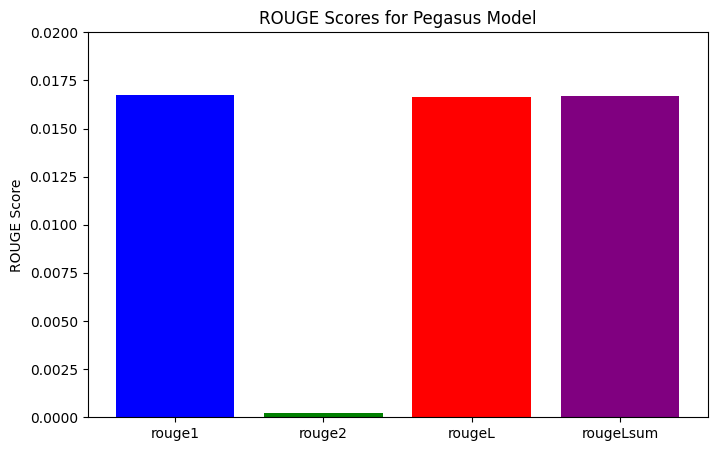

In [50]:
import matplotlib.pyplot as plt

rouge_names = list(rouge_dict.keys())
rouge_values = list(rouge_dict.values())

plt.figure(figsize=(8, 5))
plt.bar(rouge_names, rouge_values, color=['blue', 'green', 'red', 'purple'])
plt.ylabel("ROUGE Score")
plt.title("ROUGE Scores for Pegasus Model")
plt.ylim(0, 0.02) # ROUGE scores are between 0 and 0.02
plt.show()

In [27]:
# Save Model
model_pegasus.save_pretrained("pegasus-samsum-model")

In [28]:
# Save tokenizer
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [29]:
#Load
tokenizer = AutoTokenizer.from_pretrained("/content/tokenizer")

In [38]:
import logging

logging.basicConfig(level=logging.ERROR) # Set the logging level to ERROR or higher

In [39]:
import textwrap

def wrap_text(text, width):
    """Wraps text to a specified width."""
    return textwrap.fill(text, width=width)

In [42]:
# Prediction
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

sample_text = dataset_samsum["test"][0]["dialogue"]

reference = dataset_samsum["test"][0]["summary"]

pipe = pipeline("summarization", model="pegasus-samsum-model",tokenizer=tokenizer)

## Output
print("Dialogue:")
print(wrap_text(sample_text, width=80))


print("\nReference Summary:")
print(wrap_text(reference, width=80))


print("\nModel Summary:")
model_summary = pipe(sample_text, **gen_kwargs)[0]["summary_text"]
print(wrap_text(model_summary, width=80))

Dialogue:
Hannah: Hey, do you have Betty's number? Amanda: Lemme check Hannah: <file_gif>
Amanda: Sorry, can't find it. Amanda: Ask Larry Amanda: He called her last time
we were at the park together Hannah: I don't know him well Hannah: <file_gif>
Amanda: Don't be shy, he's very nice Hannah: If you say so.. Hannah: I'd rather
you texted him Amanda: Just text him 🙂 Hannah: Urgh.. Alright Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.

Model Summary:
Amanda can't find Betty's number so she asks Larry for Hannah's number .<n>Larry
called Betty the last time they were at the park together .


In [44]:
# Prediction2

sample_text = dataset_samsum["test"][2]["dialogue"]

reference = dataset_samsum["test"][2]["summary"]

pipe = pipeline("summarization", model="pegasus-samsum-model",tokenizer=tokenizer)

## Output
print("Dialogue:")
print(wrap_text(sample_text, width=80))


print("\nReference Summary:")
print(wrap_text(reference, width=80))


print("\nModel Summary:")
model_summary = pipe(sample_text, **gen_kwargs)[0]["summary_text"]
print(wrap_text(model_summary, width=80))

Dialogue:
Lenny: Babe, can you help me with something? Bob: Sure, what's up? Lenny: Which
one should I pick? Bob: Send me photos Lenny:  <file_photo> Lenny:  <file_photo>
Lenny:  <file_photo> Bob: I like the first ones best Lenny: But I already have
purple trousers. Does it make sense to have two pairs? Bob: I have four black
pairs :D :D Lenny: yeah, but shouldn't I pick a different color? Bob: what
matters is what you'll give you the most outfit options Lenny: So I guess I'll
buy the first or the third pair then Bob: Pick the best quality then Lenny: ur
right, thx Bob: no prob :)

Reference Summary:
Lenny can't decide which trousers to buy. Bob advised Lenny on that topic. Lenny
goes with Bob's advice to pick the trousers that are of best quality.

Model Summary:
Lenny and Bob are looking for a new pair of trousers. Bob already has purple
trousers. Lenny will buy the first or the third pair. Bob will buy the best
quality.


In [46]:
# Prediction3

sample_text = dataset_samsum["test"][5]["dialogue"]

reference = dataset_samsum["test"][5]["summary"]

pipe = pipeline("summarization", model="pegasus-samsum-model",tokenizer=tokenizer)

## Output
print("Dialogue:")
print(wrap_text(sample_text, width=80))


print("\nReference Summary:")
print(wrap_text(reference, width=80))


print("\nModel Summary:")
model_summary = pipe(sample_text, **gen_kwargs)[0]["summary_text"]
print(wrap_text(model_summary, width=80))

Dialogue:
Benjamin: Hey guys, what are we doing with the keys today? Hilary: I've got
them. Whoever wants them can meet me at lunchtime or after Elliot: I'm ok. We're
meeting for the drinks in the evening anyway and I guess we'll be going back to
the apartment together? Hilary: Yeah, I guess so Daniel: I'm with Hilary atm and
won't let go of her for the rest of the day, so any option you guys choose is
good for me Benjamin: Hmm I might actually pass by at lunchtime, take the keys
and go take a nap. I'm sooo tired after yesterday Hilary: Sounds good. We'll be
having lunch with some French people (the ones who work on the history of food
in colonial Mexico - I already see you yawning your head off) Benjamin: YAAAAWN
🙊 Where and where are you meeting? Hilary: So I'm meeting them at the entrance
to the conference hall at 2 pm and then we'll head to this place called La
Cantina. Italian cuisine, which is quite funny, but that's what they've chosen
Benjamin: Interesting 😱 To be honest, Hilar

**Understanding the `attention_mask`**

The `attention_mask` is a crucial component when working with transformer models.

*   **What it is:**
    *   A binary tensor (a matrix of 0s and 1s).
    *   Has the same shape as the input `input_ids`.

*   **Why it's needed:**
    *   Tokenizers often pad input sequences to a fixed length (`max_length`).
    *   Padding tokens are "dummy" tokens added to the end of shorter sequences.
    *   The attention mechanism needs to distinguish between real tokens and padding tokens.

*   **How it works:**
    *   A value of `1` indicates a real token (attend to).
    *   A value of `0` indicates a padding token (ignore).

The `attention_mask` prevents the model from attending to padding tokens, improving performance.

**ROUGE Score Explanation**

ROUGE stands for **Recall-Oriented Understudy for Gisting Evaluation**. It's a set of metrics used for evaluating automatic summarization and machine translation software. It works by comparing an automatically produced summary or translation against a set of reference summaries or translations (produced by humans).

Essentially, ROUGE measures how much the generated summary *overlaps* with the human-written reference summary in terms of n-grams (sequences of words), word pairs, or sentence sequences. Higher ROUGE scores generally indicate a better summary.

There are different types of ROUGE scores, such as:

*   **ROUGE-N:** Measures the overlap of n-grams (e.g., ROUGE-1 for unigrams, ROUGE-2 for bigrams).
*   **ROUGE-L:** Measures the longest common subsequence (LCS) between the generated and reference summaries.
*   **ROUGE-W:** A weighted LCS score.
*   **ROUGE-S:** Measures skip-bigram co-occurrence statistics.

In the context of a summarization model, you would use ROUGE scores to evaluate how well your model's generated summaries match the original summaries in your dataset.

In [41]:
import logging

logging.getLogger("transformers").setLevel(logging.ERROR)